In [20]:
import itertools
import math
import pickle
import random
from collections import defaultdict

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import PIL.Image
import seaborn as sns
import scipy.ndimage
import scipy.stats as sps
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer
import tqdm

from IPython.core.display import Image, display

%matplotlib inline
%autosave 15

Autosaving every 15 seconds


# Загружаем датасет

In [3]:
with open('./data/hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./data/hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

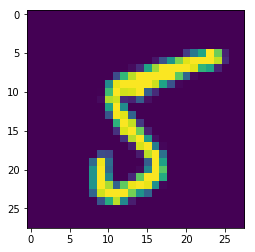

In [4]:
# Пример, как можно визуализировать данные
plt.imshow(train['data'][0].reshape(28,28));

# Обучаем модель

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def logit(X, w):
    return sigmoid(X @ w)


def predict(X, w):
    return 2 * (logit(X, w) > 0.5) - 1


def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()


def loss_grad_full(X, y, w, regparam):
#     grad = np.zeros((X.shape[1], 1))
#     for i in range(X.shape[1]):
#         features = X[i, :].reshape(-1, 1)
#         grad += -y[i]  / (1 + np.exp(y[i] * theta.T @ features)) * features
    regvec = w
    regvec[0] = 0
#     return grad + regparam * regvec
    return -X.T @ (y / (1 + np.exp(y * (X @ w))) ) + regparam * regvec


def loss_grad_stoch(X, y, w, regparam):
    grad = np.zeros((X.shape[1], 1))
    for i in range(X.shape[1]):
        j = np.random.randint(0, X.shape[0])
        fvec = X[j][:, None]
        grad += -y[j]  / (1 + np.exp(y[j] * w.T @ fvec)) * fvec + regparam * fvec      
    return grad

Я довольно долго мучился, но всё же написал в итоге хороший алгоритм.  
У меня полный градиентный спуск, поиск оптимальной длины шага с помощью тернарного поиска, кросс-валидация и подбор оптимального вектора параметров по `accuracy` на кросс-валидации. Он в итоге зашёл за отсечку `Normal`, и я этому очень рад. 

In [32]:
max_iter = 400

# Считаем данные
n_samples, n_features = train["data"].shape
X = np.column_stack((np.ones(n_samples), train["data"].copy()))

standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Приведём метки классов к {-1, 1}
y = train["labels"].copy()[:, None]
y[y == 5] = -1
y[y == 6] = 1

acc_opt = 0
weights_opt = None

kf = KFold(n_splits=10)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Выберем случайное начальное приближение вектора параметров
    weights = np.random.normal(scale=1e-3, size=n_features + 1)[:, None]
    tr_eval = []
    te_eval = []
    tolerance = 1e-7

    for i in tqdm.tqdm_notebook(range(max_iter)):
        grad = loss_grad_full(X_train, y_train, weights, regparam=0)
        grad_norm = np.linalg.norm(grad) 
        if grad_norm < tolerance:
            break

        h = grad / grad_norm
        tersearch_maxiter = 50
        lo, hi = 0, 1
        for _ in range(tersearch_maxiter):
            left_third = (2 * lo + hi) / 3
            right_third = (lo + 2 * hi) / 3
            loss_left = log_loss(y_train, 
                                 predict(X_train, weights - left_third * h), 
                                 labels=[-1,1])
            loss_right = log_loss(y_train, 
                                  predict(X_train, weights - right_third * h), 
                                  labels=[-1,1])
            if -loss_left < -loss_right:
                lo = left_third
            else:
                hi = right_third
        lr_opt = (lo + hi) / 2

        weights -= lr_opt * h
        
        y_train_pred = predict(X_train, weights)
        tr_eval += [(log_loss(y_train, y_train_pred), 
                    accuracy(y_train, y_train_pred))]
        
        y_test_pred = predict(X_test, weights)
        te_eval += [(log_loss(y_test, y_test_pred), 
                    accuracy(y_test, y_test_pred))]
        
        if te_eval[-1][1] > acc_opt:
            acc_opt = te_eval[-1][1]
            print(acc_opt)
            weights_opt = weights
            
        if len(tr_eval) > 1 and np.abs(tr_eval[-1][0] - tr_eval[-2][0]) < tolerance:
            print("Loss reached plateu")
            break

0.961
0.973
0.977
0.978
0.979
0.98
0.981
Loss reached plateu


Loss reached plateu


0.984
0.986
0.987
Loss reached plateu


Loss reached plateu


Loss reached plateu


0.988
Loss reached plateu


Loss reached plateu


Loss reached plateu


Loss reached plateu


Loss reached plateu


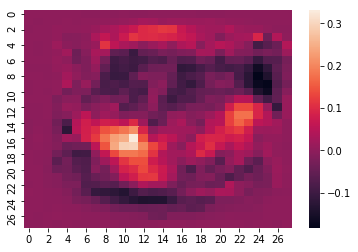

In [33]:
sns.heatmap(weights_opt[1:].reshape(28,28))

In [34]:
sps.describe(weights)

DescribeResult(nobs=785, minmax=(array([-0.19587296]), array([0.33963776])), mean=array([-0.00279309]), variance=array([0.00408665]), skewness=array([0.94900331]), kurtosis=array([3.73179236]))

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

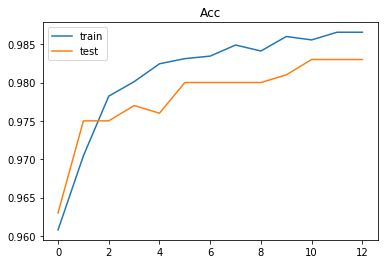

In [35]:
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend();

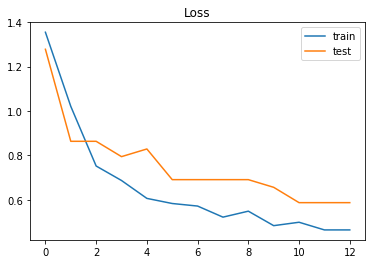

In [36]:
plt.title('Loss')
plt.plot([e[0] for e in tr_eval], label='train')
plt.plot([e[0] for e in te_eval], label='test')
plt.legend();

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [39]:
te_X = test_no_lables['data']
te_X = np.column_stack((np.ones(te_X.shape[0]), te_X))
te_X = standardizer.transform(te_X)
te_y_pred = logit(te_X, weights_opt)

with open('solution_fullgrad_no_reg_400_iters_max_acc.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(te_y_pred.size):
        print(i, *te_y_pred[i], sep=',', file=fout)

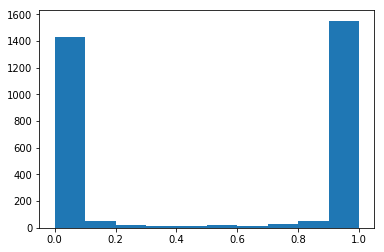

In [40]:
bins, _, _ = plt.hist(te_y_pred)

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/34e77301ef914c5792e4f4306144a6b3 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МФТИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем <ваша фамилия>.ipynb